# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [1]:
! pip install SimpleITK==1.2.4 

### Downloading the data

In [3]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-03-03 05:29:52--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M   792KB/s    in 9m 35s  

2021-03-03 05:39:28 (796 KB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating:

### Setting data directory

In [1]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [2]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

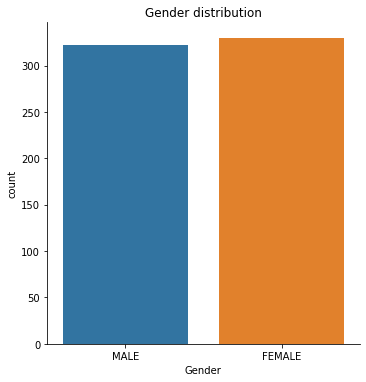

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


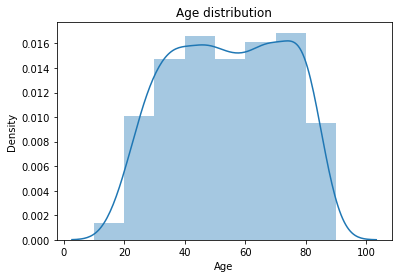

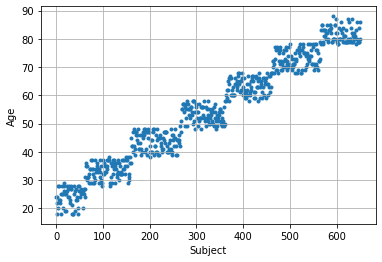

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [4]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


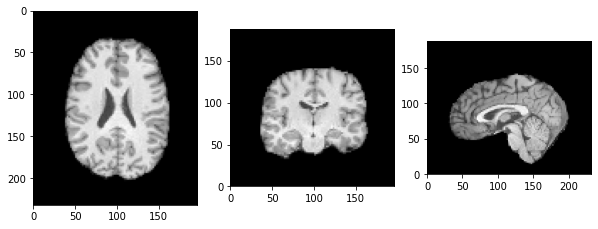

Brain mask


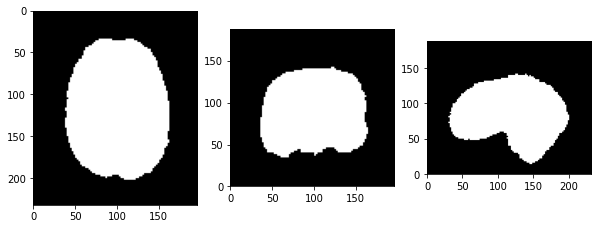

In [5]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [7]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [8]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla P100-PCIE-16GB


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [9]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100

learning_rate_simple_net = 0.001
learning_rate_lenet = 1e-4

batch_size_simple_net = 4
batch_size_lenet = 2

val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [10]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

For lenet with batch size = 2

In [11]:
# LOAD TRAINING DATA
dataset_train_taskA1_lenet = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train_taskA1_lenet = torch.utils.data.DataLoader(dataset_train_taskA1_lenet, batch_size=batch_size_lenet, shuffle=True)

# LOAD VALIDATION DATA
dataset_val_taskA1_lenet = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val_taskA1_lenet = torch.utils.data.DataLoader(dataset_val_taskA1_lenet, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


For simple net with batch size = 4

In [12]:
# LOAD TRAINING DATA
dataset_train_taskA1_simple_net = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train_taskA1_simple_net = torch.utils.data.DataLoader(dataset_train_taskA1_simple_net, batch_size=batch_size_simple_net, shuffle=True)

# LOAD VALIDATION DATA
dataset_val_taskA1_simple_net = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val_taskA1_simple_net = torch.utils.data.DataLoader(dataset_val_taskA1_simple_net, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


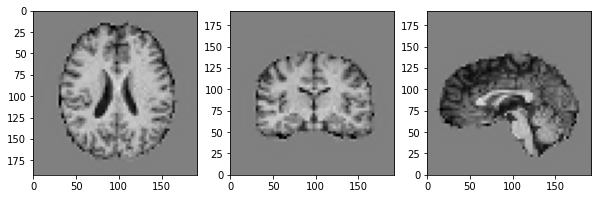

Segmentation


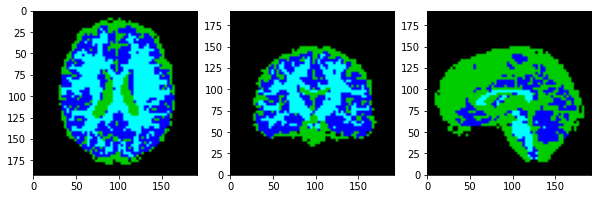

Mask


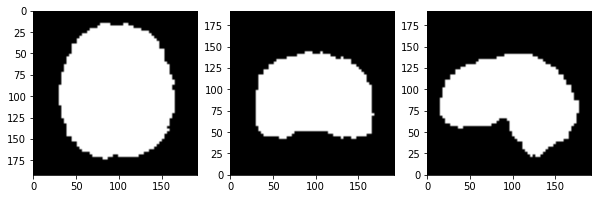

In [13]:
sample = dataset_train_taskA1_simple_net.get_sample(0)
img_name = dataset_train_taskA1_simple_net.get_img_name(0)
seg_name = dataset_train_taskA1_simple_net.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.



# FCLeNet
**We implement two models. One is LeNet, another one is a Simple3DNet. The LeNet has a more complex structure than Simple3DNet. But the result of Simple3DNet in Task A.3 is better than LeNet.**

In [14]:
########################################
# First choice, FCLeNet
########################################
class FCLeNet_Seg(nn.Module):
    def __init__(self, num_classes):
        super(FCLeNet_Seg, self).__init__()
        # Downsampling
        self.conv1 = nn.Conv3d(1, 6, kernel_size=5, bias=True, padding=0)
        self.conv2 = nn.Conv3d(6, 16, kernel_size=5, bias=True, padding=0)
        self.conv3 = nn.Conv3d(16, 64, kernel_size=5, bias=True, padding=0)
        self.conv4 = nn.Conv3d(64, 128, kernel_size=4,
                               stride=2, bias=True, padding=0)
        self.conv5 = nn.Conv3d(128, 84, kernel_size=1, bias=True, padding=0)

        # Upsampling
        self.conv_ups1 = nn.ConvTranspose3d(
            84, 84, kernel_size=5, stride=1, padding=0, bias=False)
        self.conv_ups2 = nn.ConvTranspose3d(
            84, 84, kernel_size=5, stride=2, padding=0, bias=False)
        self.conv_ups3 = nn.ConvTranspose3d(
            84, 84, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv6 = nn.Conv3d(
            84, num_classes, kernel_size=1, bias=True, padding=0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = self.conv_ups1(x)
        x = self.conv_ups2(x)
        x = self.conv_ups3(x)

        x = self.conv6(x)

        return x

#### TRAINING FCLeNet_Seg. If you do not have enough time, you could test our simple 3D net, which has a better result and will not take too much time.

This is train function for FCLeNet. This net will cost much time(30minutes)

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.722961
+ Validation 	Loss: 0.621487
Validation dice scores: background:0.9600737690925598; CSF:0.11385239660739899; GM:0.020681053400039673; WM:0.4917663633823395
average dice score: 0.3965933918952942
show the prediction picture


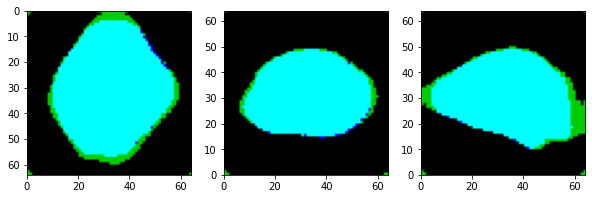

+ TRAINING 	Epoch: 2 	Loss: 0.600756
+ TRAINING 	Epoch: 3 	Loss: 0.441001
+ TRAINING 	Epoch: 4 	Loss: 0.351886
+ TRAINING 	Epoch: 5 	Loss: 0.370587
+ TRAINING 	Epoch: 6 	Loss: 0.297058
+ TRAINING 	Epoch: 7 	Loss: 0.308483
+ TRAINING 	Epoch: 8 	Loss: 0.297243
+ TRAINING 	Epoch: 9 	Loss: 0.321094
+ TRAINING 	Epoch: 10 	Loss: 0.280569
+ Validation 	Loss: 0.264562
Validation dice scores: background:0.9850977659225464; CSF:0.4823163151741028; GM:0.623328447341919; WM:0.6596516966819763
average dice score: 0.6875985860824585
show the prediction picture


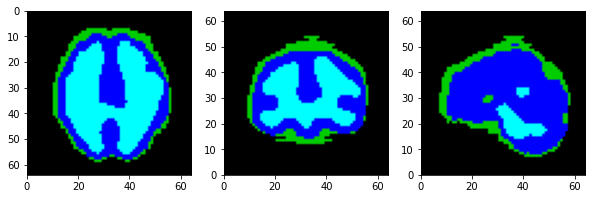

+ TRAINING 	Epoch: 11 	Loss: 0.258051
+ TRAINING 	Epoch: 12 	Loss: 0.297193
+ TRAINING 	Epoch: 13 	Loss: 0.295283
+ TRAINING 	Epoch: 14 	Loss: 0.299041
+ TRAINING 	Epoch: 15 	Loss: 0.236676
+ TRAINING 	Epoch: 16 	Loss: 0.232826
+ TRAINING 	Epoch: 17 	Loss: 0.220255
+ TRAINING 	Epoch: 18 	Loss: 0.284450
+ TRAINING 	Epoch: 19 	Loss: 0.246146
+ TRAINING 	Epoch: 20 	Loss: 0.249742
+ Validation 	Loss: 0.218829
Validation dice scores: background:0.9879119992256165; CSF:0.5547870993614197; GM:0.6689326167106628; WM:0.6916922330856323
average dice score: 0.7258310317993164
show the prediction picture


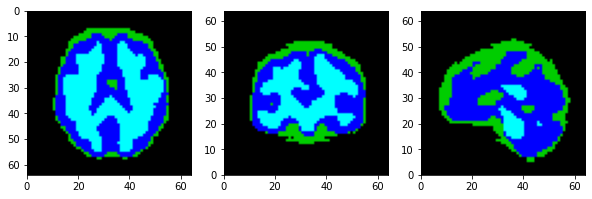

+ TRAINING 	Epoch: 21 	Loss: 0.217861
+ TRAINING 	Epoch: 22 	Loss: 0.219873
+ TRAINING 	Epoch: 23 	Loss: 0.193807
+ TRAINING 	Epoch: 24 	Loss: 0.244899
+ TRAINING 	Epoch: 25 	Loss: 0.201435
+ TRAINING 	Epoch: 26 	Loss: 0.223164
+ TRAINING 	Epoch: 27 	Loss: 0.238020
+ TRAINING 	Epoch: 28 	Loss: 0.233651
+ TRAINING 	Epoch: 29 	Loss: 0.225855
+ TRAINING 	Epoch: 30 	Loss: 0.188136
+ Validation 	Loss: 0.208898
Validation dice scores: background:0.9870387315750122; CSF:0.618524432182312; GM:0.6512863039970398; WM:0.7144953608512878
average dice score: 0.7428362369537354
show the prediction picture


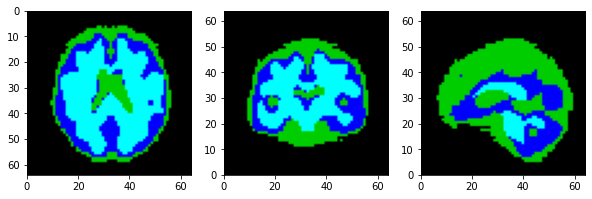

+ TRAINING 	Epoch: 31 	Loss: 0.161389
+ TRAINING 	Epoch: 32 	Loss: 0.187398
+ TRAINING 	Epoch: 33 	Loss: 0.207776
+ TRAINING 	Epoch: 34 	Loss: 0.242683
+ TRAINING 	Epoch: 35 	Loss: 0.174650
+ TRAINING 	Epoch: 36 	Loss: 0.203160
+ TRAINING 	Epoch: 37 	Loss: 0.211034
+ TRAINING 	Epoch: 38 	Loss: 0.169995
+ TRAINING 	Epoch: 39 	Loss: 0.180111
+ TRAINING 	Epoch: 40 	Loss: 0.169509
+ Validation 	Loss: 0.188338
Validation dice scores: background:0.9884457588195801; CSF:0.6366016864776611; GM:0.6860124468803406; WM:0.7287100553512573
average dice score: 0.7599425315856934
show the prediction picture


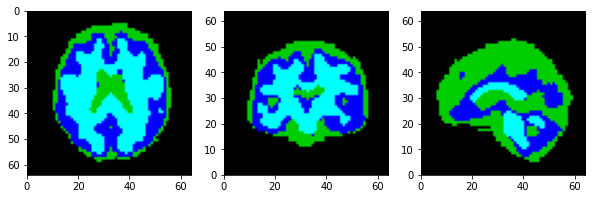

+ TRAINING 	Epoch: 41 	Loss: 0.247462
+ TRAINING 	Epoch: 42 	Loss: 0.194751
+ TRAINING 	Epoch: 43 	Loss: 0.239853
+ TRAINING 	Epoch: 44 	Loss: 0.168014
+ TRAINING 	Epoch: 45 	Loss: 0.213426
+ TRAINING 	Epoch: 46 	Loss: 0.189729
+ TRAINING 	Epoch: 47 	Loss: 0.191230
+ TRAINING 	Epoch: 48 	Loss: 0.185109
+ TRAINING 	Epoch: 49 	Loss: 0.171748
+ TRAINING 	Epoch: 50 	Loss: 0.180304
+ Validation 	Loss: 0.175600
Validation dice scores: background:0.9896715879440308; CSF:0.6500923037528992; GM:0.6928414106369019; WM:0.7448939085006714
average dice score: 0.7693748474121094
show the prediction picture


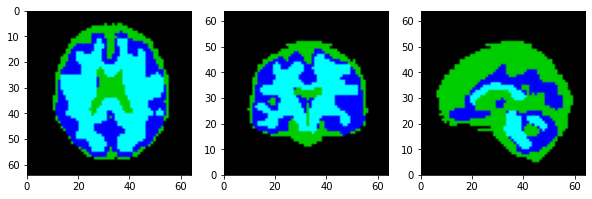

+ TRAINING 	Epoch: 51 	Loss: 0.171095
+ TRAINING 	Epoch: 52 	Loss: 0.168199
+ TRAINING 	Epoch: 53 	Loss: 0.176149
+ TRAINING 	Epoch: 54 	Loss: 0.177091
+ TRAINING 	Epoch: 55 	Loss: 0.188084
+ TRAINING 	Epoch: 56 	Loss: 0.157237
+ TRAINING 	Epoch: 57 	Loss: 0.154513
+ TRAINING 	Epoch: 58 	Loss: 0.163041
+ TRAINING 	Epoch: 59 	Loss: 0.159756
+ TRAINING 	Epoch: 60 	Loss: 0.153134
+ Validation 	Loss: 0.169881
Validation dice scores: background:0.9898551106452942; CSF:0.6592556238174438; GM:0.7270835638046265; WM:0.7412786483764648
average dice score: 0.7793682813644409
show the prediction picture


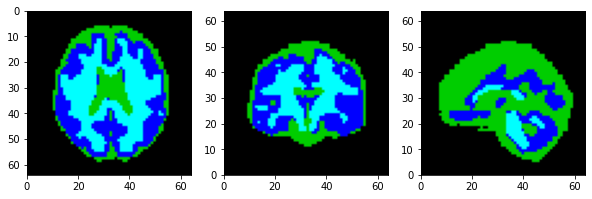

+ TRAINING 	Epoch: 61 	Loss: 0.170195
+ TRAINING 	Epoch: 62 	Loss: 0.168304
+ TRAINING 	Epoch: 63 	Loss: 0.171546
+ TRAINING 	Epoch: 64 	Loss: 0.141764
+ TRAINING 	Epoch: 65 	Loss: 0.149896
+ TRAINING 	Epoch: 66 	Loss: 0.178373
+ TRAINING 	Epoch: 67 	Loss: 0.172648
+ TRAINING 	Epoch: 68 	Loss: 0.145876
+ TRAINING 	Epoch: 69 	Loss: 0.151592
+ TRAINING 	Epoch: 70 	Loss: 0.148362
+ Validation 	Loss: 0.163661
Validation dice scores: background:0.9899986386299133; CSF:0.6607360243797302; GM:0.7544148564338684; WM:0.7421126961708069
average dice score: 0.7868155241012573
show the prediction picture


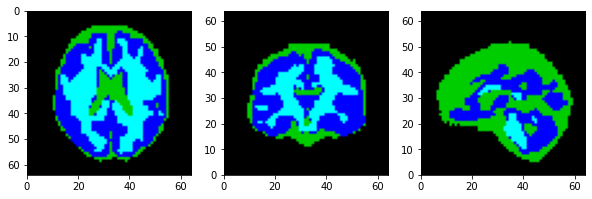

+ TRAINING 	Epoch: 71 	Loss: 0.155022
+ TRAINING 	Epoch: 72 	Loss: 0.167540
+ TRAINING 	Epoch: 73 	Loss: 0.170889
+ TRAINING 	Epoch: 74 	Loss: 0.164538
+ TRAINING 	Epoch: 75 	Loss: 0.167599
+ TRAINING 	Epoch: 76 	Loss: 0.145503
+ TRAINING 	Epoch: 77 	Loss: 0.155188
+ TRAINING 	Epoch: 78 	Loss: 0.184477
+ TRAINING 	Epoch: 79 	Loss: 0.140353
+ TRAINING 	Epoch: 80 	Loss: 0.202408
+ Validation 	Loss: 0.155871
Validation dice scores: background:0.9900293350219727; CSF:0.6624531745910645; GM:0.7569378018379211; WM:0.781316339969635
average dice score: 0.7976841330528259
show the prediction picture


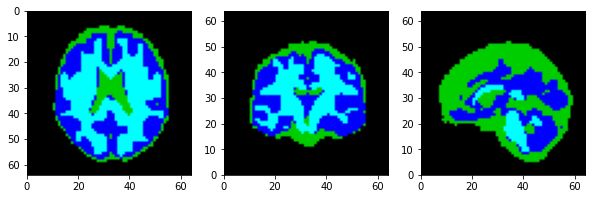

+ TRAINING 	Epoch: 81 	Loss: 0.147289
+ TRAINING 	Epoch: 82 	Loss: 0.154659
+ TRAINING 	Epoch: 83 	Loss: 0.177547
+ TRAINING 	Epoch: 84 	Loss: 0.164106
+ TRAINING 	Epoch: 85 	Loss: 0.175713
+ TRAINING 	Epoch: 86 	Loss: 0.154880
+ TRAINING 	Epoch: 87 	Loss: 0.160862
+ TRAINING 	Epoch: 88 	Loss: 0.162441
+ TRAINING 	Epoch: 89 	Loss: 0.134641
+ TRAINING 	Epoch: 90 	Loss: 0.175301
+ Validation 	Loss: 0.150960
Validation dice scores: background:0.9905074834823608; CSF:0.6854626536369324; GM:0.7731601595878601; WM:0.7665702700614929
average dice score: 0.8039251565933228
show the prediction picture


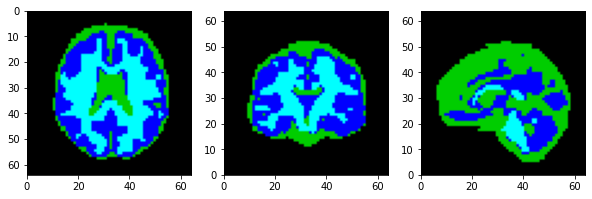

+ TRAINING 	Epoch: 91 	Loss: 0.147486
+ TRAINING 	Epoch: 92 	Loss: 0.156225
+ TRAINING 	Epoch: 93 	Loss: 0.161564
+ TRAINING 	Epoch: 94 	Loss: 0.168187
+ TRAINING 	Epoch: 95 	Loss: 0.144493
+ TRAINING 	Epoch: 96 	Loss: 0.156104
+ TRAINING 	Epoch: 97 	Loss: 0.157652
+ TRAINING 	Epoch: 98 	Loss: 0.137363
+ TRAINING 	Epoch: 99 	Loss: 0.147607
+ TRAINING 	Epoch: 100 	Loss: 0.141136
+ Validation 	Loss: 0.144179
Validation dice scores: background:0.9905455708503723; CSF:0.7022967338562012; GM:0.7662636041641235; WM:0.7973709106445312
average dice score: 0.8141192197799683
show the prediction picture


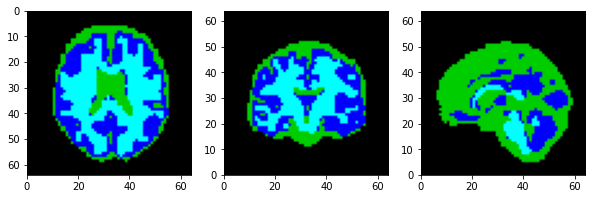


Finished TRAINING.


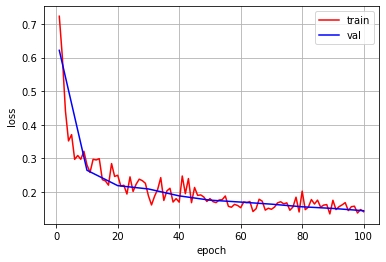

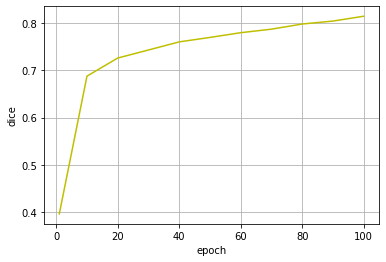

In [16]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


model_dir = os.path.join(out_dir, 'FCLeNet_Seg')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = FCLeNet_Seg(num_classes=num_classes).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_lenet)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
average_dice_val_log = []

print('START TRAINING...')

for epoch in range(1, num_epochs + 1):
    model.train()
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train_taskA1_lenet):
        img = batch_samples['img'].to(device)
        seg = batch_samples['seg'].to(device)

        optimizer.zero_grad()
        prd = model(img)

        prd_flat = prd.view(prd.size(0), prd.size(1), -1)

        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))

        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        model.eval()

        loss_val = 0
        sum_pts = 0
        idx_val = 0
        dice_val = 0
        dice_scores = []
        with torch.no_grad():
          for data_sample in dataloader_val_taskA1_lenet:
            img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)

            prd = model(img)
            prd_flat = prd.view(prd.size(0), prd.size(1), -1)
            seg_flat = seg.view(seg.size(0), seg.size(1), -1)
            loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
            sum_pts += seg_flat.size(2)

            prd = torch.argmax(prd, dim=1)
            
            ################### calculate dice ###########################
            label = seg.cpu().squeeze(1)
            labels = F.one_hot(label, num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            labels = labels.view(labels.size(0), labels.size(1), -1)

            pred = F.one_hot(prd.cpu(), num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            pred = pred.view(pred.size(0), pred.size(1), -1)
            
            intersection = (labels * pred).sum(-1) 
            denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

            dice_score_per_channel = 2 * (intersection / denominator.clamp(min=1e-8))

            ################### end ###########################

            dice_val += dice_score_per_channel
            dice_scores.append(dice_score_per_channel.numpy())

            idx_val += 1

        loss_val /= sum_pts
        dice_val /= idx_val
        dice_val = dice_val.squeeze()
        print('+ Validation \tLoss: {:.6f}'.format(loss_val))
        print(f'Validation dice scores: background:{dice_val[0]}; CSF:{dice_val[1]}; GM:{dice_val[2]}; WM:{dice_val[3]}')
        
        mean_dice = torch.mean(dice_val)
        
        print(f'average dice score: {mean_dice}')
        print('show the prediction picture')

        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        display_image(sitk.LabelToRGB(prediction, sitk.sitkInt8))

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        average_dice_val_log.append(mean_dice)
            
torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(epoch_val_log, average_dice_val_log, c='y', label='dice')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('dice')
plt.show()

# **SimpleNet**

In [17]:
feat_map_const = 9

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv3d(1, 2*feat_map_const, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm3d(feat_map_const*2)

        self.conv2 = nn.Conv3d(2*feat_map_const, 4*feat_map_const, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm3d(feat_map_const*4)

        self.conv3 = nn.Conv3d(4*feat_map_const, 6*feat_map_const, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm3d(feat_map_const*6)

        self.conv4 = nn.Conv3d(6*feat_map_const, 3*feat_map_const, kernel_size=1)
        self.conv4_bn = nn.BatchNorm3d(feat_map_const*3)

        self.conv5 = nn.Conv3d(3*feat_map_const, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.conv5(x)
        return F.softmax(x, dim=1)


# Train
Train the simple net.

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.189201
+ Validation Loss: 1.283405
Validation dice scores: background:0.9727786779403687; CSF:0.5749503374099731; GM:0.6113029718399048; WM:0.7132968306541443
average dice score: 0.7180821895599365
show the prediction picture


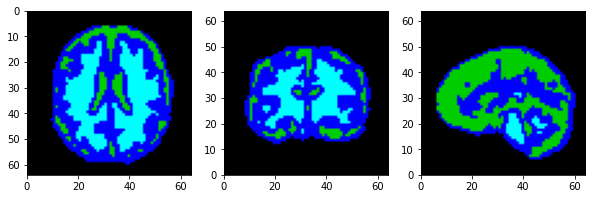

+ TRAINING 	Epoch: 2 	Loss: 1.120869
+ TRAINING 	Epoch: 3 	Loss: 1.068762
+ TRAINING 	Epoch: 4 	Loss: 1.012593
+ TRAINING 	Epoch: 5 	Loss: 0.980970
+ TRAINING 	Epoch: 6 	Loss: 0.945979
+ TRAINING 	Epoch: 7 	Loss: 0.922743
+ TRAINING 	Epoch: 8 	Loss: 0.894620
+ TRAINING 	Epoch: 9 	Loss: 0.880228
+ TRAINING 	Epoch: 10 	Loss: 0.871195
+ Validation Loss: 0.873554
Validation dice scores: background:0.9675591588020325; CSF:0.6094039082527161; GM:0.8373705148696899; WM:0.8695353269577026
average dice score: 0.8209671974182129
show the prediction picture


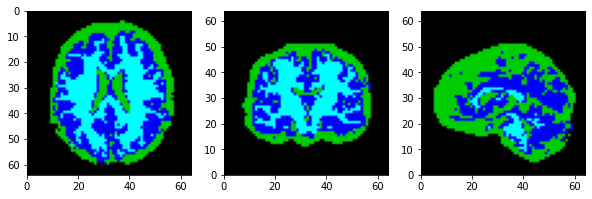

+ TRAINING 	Epoch: 11 	Loss: 0.857549
+ TRAINING 	Epoch: 12 	Loss: 0.849357
+ TRAINING 	Epoch: 13 	Loss: 0.839372
+ TRAINING 	Epoch: 14 	Loss: 0.829893
+ TRAINING 	Epoch: 15 	Loss: 0.830409
+ TRAINING 	Epoch: 16 	Loss: 0.819405
+ TRAINING 	Epoch: 17 	Loss: 0.817456
+ TRAINING 	Epoch: 18 	Loss: 0.813967
+ TRAINING 	Epoch: 19 	Loss: 0.809910
+ TRAINING 	Epoch: 20 	Loss: 0.803169
+ Validation Loss: 0.805343
Validation dice scores: background:0.9883139729499817; CSF:0.745676577091217; GM:0.8569984436035156; WM:0.8837990760803223
average dice score: 0.8686970472335815
show the prediction picture


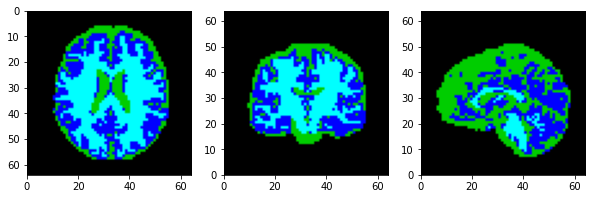

+ TRAINING 	Epoch: 21 	Loss: 0.802918
+ TRAINING 	Epoch: 22 	Loss: 0.802719
+ TRAINING 	Epoch: 23 	Loss: 0.814569
+ TRAINING 	Epoch: 24 	Loss: 0.798520
+ TRAINING 	Epoch: 25 	Loss: 0.797603
+ TRAINING 	Epoch: 26 	Loss: 0.794153
+ TRAINING 	Epoch: 27 	Loss: 0.793077
+ TRAINING 	Epoch: 28 	Loss: 0.797133
+ TRAINING 	Epoch: 29 	Loss: 0.793458
+ TRAINING 	Epoch: 30 	Loss: 0.793402
+ Validation Loss: 0.794649
Validation dice scores: background:0.9892921447753906; CSF:0.7635108828544617; GM:0.8467124104499817; WM:0.8908959627151489
average dice score: 0.8726028203964233
show the prediction picture


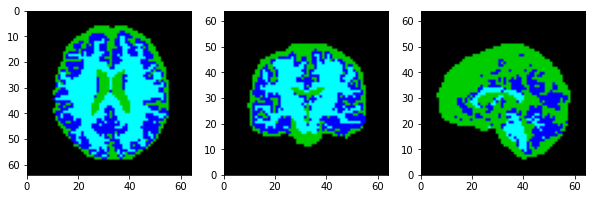

+ TRAINING 	Epoch: 31 	Loss: 0.789410
+ TRAINING 	Epoch: 32 	Loss: 0.797682
+ TRAINING 	Epoch: 33 	Loss: 0.791383
+ TRAINING 	Epoch: 34 	Loss: 0.789582
+ TRAINING 	Epoch: 35 	Loss: 0.792559
+ TRAINING 	Epoch: 36 	Loss: 0.785380
+ TRAINING 	Epoch: 37 	Loss: 0.785892
+ TRAINING 	Epoch: 38 	Loss: 0.792721
+ TRAINING 	Epoch: 39 	Loss: 0.795039
+ TRAINING 	Epoch: 40 	Loss: 0.789216
+ Validation Loss: 0.789901
Validation dice scores: background:0.9896880984306335; CSF:0.7271649241447449; GM:0.8620363473892212; WM:0.8925922513008118
average dice score: 0.8678703904151917
show the prediction picture


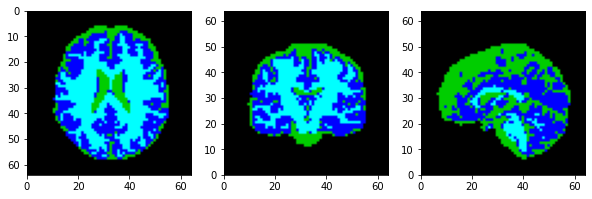

+ TRAINING 	Epoch: 41 	Loss: 0.789012
+ TRAINING 	Epoch: 42 	Loss: 0.789287
+ TRAINING 	Epoch: 43 	Loss: 0.785779
+ TRAINING 	Epoch: 44 	Loss: 0.792374
+ TRAINING 	Epoch: 45 	Loss: 0.784509
+ TRAINING 	Epoch: 46 	Loss: 0.789251
+ TRAINING 	Epoch: 47 	Loss: 0.797588
+ TRAINING 	Epoch: 48 	Loss: 0.789011
+ TRAINING 	Epoch: 49 	Loss: 0.790480
+ TRAINING 	Epoch: 50 	Loss: 0.782930
+ Validation Loss: 0.785614
Validation dice scores: background:0.9899261593818665; CSF:0.7639726400375366; GM:0.8754373788833618; WM:0.8950504064559937
average dice score: 0.8810967206954956
show the prediction picture


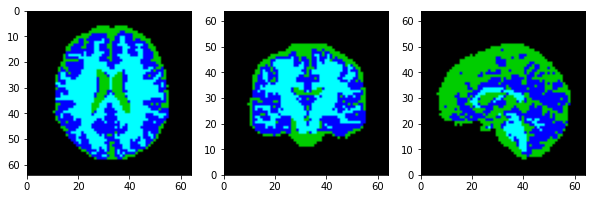

+ TRAINING 	Epoch: 51 	Loss: 0.788084
+ TRAINING 	Epoch: 52 	Loss: 0.784149
+ TRAINING 	Epoch: 53 	Loss: 0.787346
+ TRAINING 	Epoch: 54 	Loss: 0.790600
+ TRAINING 	Epoch: 55 	Loss: 0.784455
+ TRAINING 	Epoch: 56 	Loss: 0.792049
+ TRAINING 	Epoch: 57 	Loss: 0.791317
+ TRAINING 	Epoch: 58 	Loss: 0.784699
+ TRAINING 	Epoch: 59 	Loss: 0.781587
+ TRAINING 	Epoch: 60 	Loss: 0.791003
+ Validation Loss: 0.787422
Validation dice scores: background:0.9900590777397156; CSF:0.7823936939239502; GM:0.8674370050430298; WM:0.8626266717910767
average dice score: 0.8756290674209595
show the prediction picture


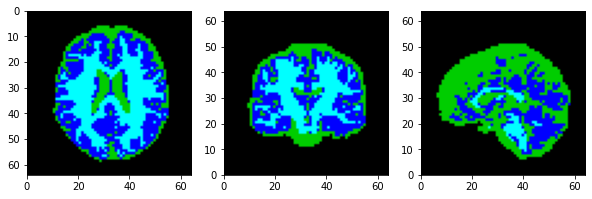

+ TRAINING 	Epoch: 61 	Loss: 0.786385
+ TRAINING 	Epoch: 62 	Loss: 0.791268
+ TRAINING 	Epoch: 63 	Loss: 0.791364
+ TRAINING 	Epoch: 64 	Loss: 0.783776
+ TRAINING 	Epoch: 65 	Loss: 0.780768
+ TRAINING 	Epoch: 66 	Loss: 0.784781
+ TRAINING 	Epoch: 67 	Loss: 0.785065
+ TRAINING 	Epoch: 68 	Loss: 0.784896
+ TRAINING 	Epoch: 69 	Loss: 0.787281
+ TRAINING 	Epoch: 70 	Loss: 0.782483
+ Validation Loss: 0.784240
Validation dice scores: background:0.990277111530304; CSF:0.7871701121330261; GM:0.8643398284912109; WM:0.891827404499054
average dice score: 0.8834035992622375
show the prediction picture


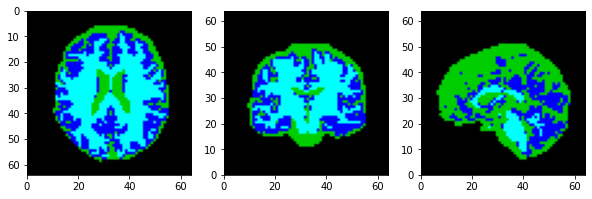

+ TRAINING 	Epoch: 71 	Loss: 0.782537
+ TRAINING 	Epoch: 72 	Loss: 0.786743
+ TRAINING 	Epoch: 73 	Loss: 0.783187
+ TRAINING 	Epoch: 74 	Loss: 0.782039
+ TRAINING 	Epoch: 75 	Loss: 0.788441
+ TRAINING 	Epoch: 76 	Loss: 0.782726
+ TRAINING 	Epoch: 77 	Loss: 0.785908
+ TRAINING 	Epoch: 78 	Loss: 0.784089
+ TRAINING 	Epoch: 79 	Loss: 0.781737
+ TRAINING 	Epoch: 80 	Loss: 0.781110
+ Validation Loss: 0.784973
Validation dice scores: background:0.9902337789535522; CSF:0.7522609829902649; GM:0.8709720373153687; WM:0.8925825357437134
average dice score: 0.8765122890472412
show the prediction picture


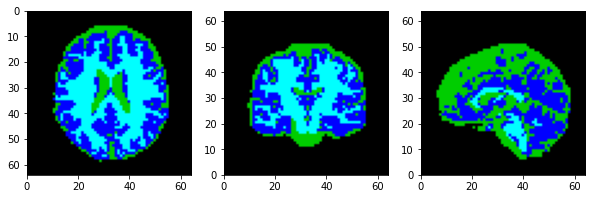

+ TRAINING 	Epoch: 81 	Loss: 0.781062
+ TRAINING 	Epoch: 82 	Loss: 0.779871
+ TRAINING 	Epoch: 83 	Loss: 0.781526
+ TRAINING 	Epoch: 84 	Loss: 0.787977
+ TRAINING 	Epoch: 85 	Loss: 0.790350
+ TRAINING 	Epoch: 86 	Loss: 0.781472
+ TRAINING 	Epoch: 87 	Loss: 0.786944
+ TRAINING 	Epoch: 88 	Loss: 0.781378
+ TRAINING 	Epoch: 89 	Loss: 0.780788
+ TRAINING 	Epoch: 90 	Loss: 0.787975
+ Validation Loss: 0.783488
Validation dice scores: background:0.9903545379638672; CSF:0.786602795124054; GM:0.8722580075263977; WM:0.894088864326477
average dice score: 0.8858259916305542
show the prediction picture


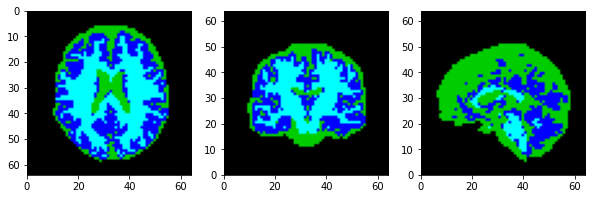

+ TRAINING 	Epoch: 91 	Loss: 0.781222
+ TRAINING 	Epoch: 92 	Loss: 0.783476
+ TRAINING 	Epoch: 93 	Loss: 0.786307
+ TRAINING 	Epoch: 94 	Loss: 0.794337
+ TRAINING 	Epoch: 95 	Loss: 0.782735
+ TRAINING 	Epoch: 96 	Loss: 0.783894
+ TRAINING 	Epoch: 97 	Loss: 0.785304
+ TRAINING 	Epoch: 98 	Loss: 0.780775
+ TRAINING 	Epoch: 99 	Loss: 0.782749
+ TRAINING 	Epoch: 100 	Loss: 0.778674
+ Validation Loss: 0.781384
Validation dice scores: background:0.990362286567688; CSF:0.7847398519515991; GM:0.8809021711349487; WM:0.9017165303230286
average dice score: 0.8894302248954773
show the prediction picture


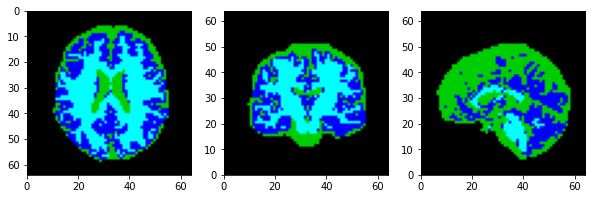


Finished TRAINING.


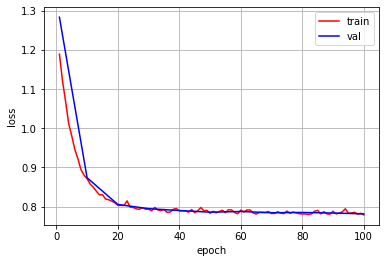

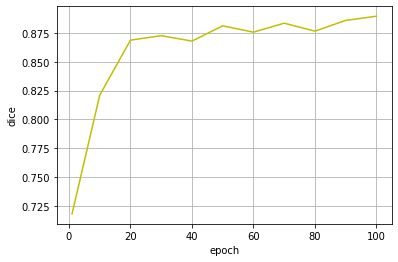

In [18]:
import sys
import numpy
import time
numpy.set_printoptions(threshold=sys.maxsize)


model_dir = os.path.join(out_dir, 'SimpleNet3D_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = SimpleNet3D(num_classes=num_classes).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_simple_net)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
average_dice_val_log = []

print('START TRAINING...')

for epoch in range(1, num_epochs + 1):
    model.train()
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train_taskA1_simple_net):
        img = batch_samples['img'].to(device)
        seg = batch_samples['seg'].to(device)

        optimizer.zero_grad()
        prd = model(img)

        prd_flat = prd.view(prd.size(0), prd.size(1), -1)

        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))

        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        model.eval()
        loss_val = 0
        sum_pts = 0
        idx_val = 0
        dice_val = 0
        dice_scores = []
        with torch.no_grad():
          for data_sample in dataloader_val_taskA1_simple_net:
            img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)

            prd = model(img)
            prd_flat = prd.view(prd.size(0), prd.size(1), -1)
            seg_flat = seg.view(seg.size(0), seg.size(1), -1)
            loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
            sum_pts += seg_flat.size(2)

            prd = torch.argmax(prd, dim=1)

            ################### calculate dice ###########################

            label = seg.cpu().squeeze(1)
            labels = F.one_hot(label, num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            labels = labels.view(labels.size(0), labels.size(1), -1)

            pred = F.one_hot(prd.cpu(), num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            pred = pred.view(pred.size(0), pred.size(1), -1)
            
            intersection = (labels * pred).sum(-1) 
            denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

            dice_score_per_channel = 2 * (intersection / denominator.clamp(min=1e-8))

            dice_val += dice_score_per_channel
            dice_scores.append(dice_score_per_channel.numpy())

            idx_val += 1
        
        

        loss_val /= sum_pts
        dice_val /= idx_val
        dice_val = dice_val.squeeze()
        print('+ Validation Loss: {:.6f}'.format(loss_val))
        print(f'Validation dice scores: background:{dice_val[0]}; CSF:{dice_val[1]}; GM:{dice_val[2]}; WM:{dice_val[3]}')
        
        mean_dice = torch.mean(dice_val)
        
        print(f'average dice score: {mean_dice}')
        print('show the prediction picture')
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        display_image(sitk.LabelToRGB(prediction, sitk.sitkInt8))

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        average_dice_val_log.append(mean_dice)
            
torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(epoch_val_log, average_dice_val_log, c='y', label='dice')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('dice')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [19]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False)

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC321594_T1w_unbiased.nii.gz


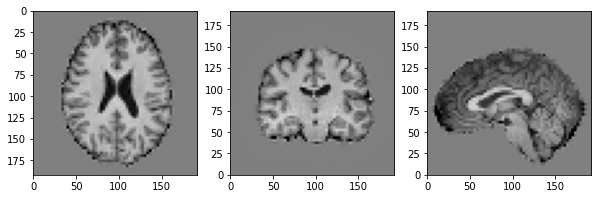

Segmentation


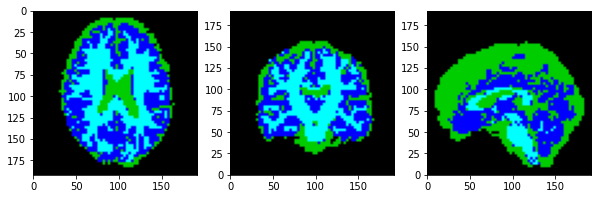

Mask


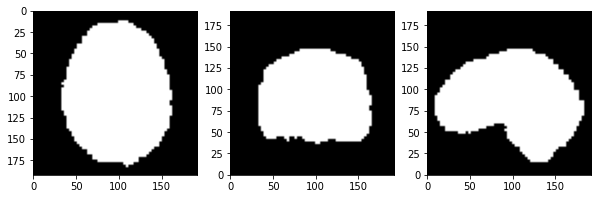

In [20]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

In [21]:
pred_dir = os.path.join(out_dir, 'SimpleNet3D_model_pred')
model_dir = os.path.join(out_dir, 'SimpleNet3D_model')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)


def get_pred(dataloader, dataset):
    '''Returns dice score for batch of images'''
    
    model = SimpleNet3D(num_classes=num_classes)
    model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
    model.to(device)
    model.eval()

    print('START TESTING...')

    loss_test = 0
    sum_pts = 0
    idx_test = 0
    dice_test = 0
    dice_scores = []
    with torch.no_grad():
        for data_sample in dataloader:
            img, seg = data_sample['img'].to(
                device), data_sample['seg'].to(device)

            prd = model(img)
            prd_flat = prd.view(prd.size(0), prd.size(1), -1)
            seg_flat = seg.view(seg.size(0), seg.size(1), -1) 
            loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
            sum_pts += seg_flat.size(2)

            prd = torch.argmax(prd, dim=1)

            label = seg.cpu().squeeze(1)
            labels = F.one_hot(label, num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            labels = labels.view(labels.size(0), labels.size(1), -1)

            pred = F.one_hot(prd.cpu(), num_classes=4).permute(0, 4, 1, 2, 3).type(torch.FloatTensor)
            pred = pred.view(pred.size(0), pred.size(1), -1)
            
            intersection = (labels * pred).sum(-1) 
            denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

            dice_score_per_channel = 2 * (intersection / denominator.clamp(min=1e-6))

            dice_test += dice_score_per_channel
            dice_scores.append(dice_score_per_channel.numpy())

            sample = dataset.get_sample(idx_test)
            name = dataset.get_seg_name(idx_test)
            
            prediction = sitk.GetImageFromArray(
                prd.cpu().squeeze().numpy().astype(np.uint8))
            
            prediction.CopyInformation(sample['seg'])
            sitk.WriteImage(prediction, os.path.join(pred_dir, name))

            idx_test += 1


    loss_test /= sum_pts
    dice_test /= idx_test
    dice_test = dice_test.squeeze()
    print('Test Loss: {:.5f}'.format(loss_test))
    print(f'Test dice scores: background:{dice_test[0]}; CSF:{dice_test[1]}; GM:{dice_test[2]}; WM:{dice_test[3]}')
    print(f'average dice scores: {torch.mean(dice_test)}')

    # Show sample as an example
    print('\nReference segmentation')
    display_image(sitk.LabelToRGB(sample['seg']))
    print('Predicted segmentation')
    display_image(sitk.LabelToRGB(prediction))

    print('\nFinished test.')
    return dice_scores



START TESTING...
Test Loss: 0.78568
Test dice scores: background:0.9895870089530945; CSF:0.7721732258796692; GM:0.8617815375328064; WM:0.8947418332099915
average dice scores: 0.8795709013938904

Reference segmentation


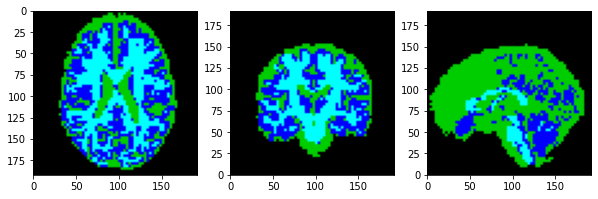

Predicted segmentation


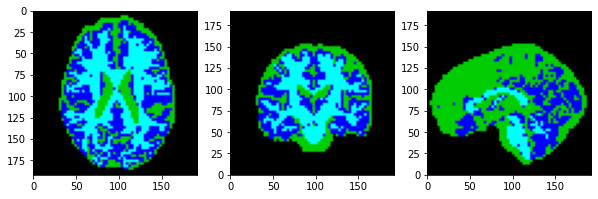


Finished test.
START TESTING...
Test Loss: 0.78489
Test dice scores: background:0.9900943636894226; CSF:0.7702217698097229; GM:0.8619358539581299; WM:0.8935298323631287
average dice scores: 0.8789454698562622

Reference segmentation


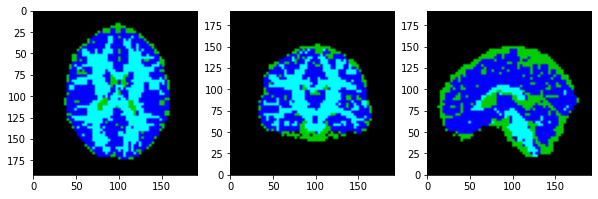

Predicted segmentation


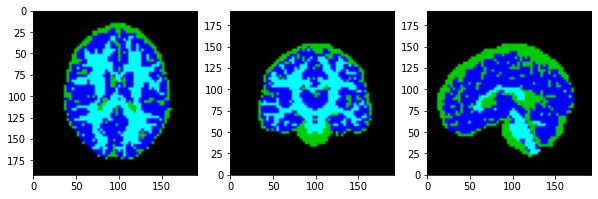


Finished test.


In [23]:
  
dice_train = get_pred(dataloader_train, dataset_train)
dice_train = np.squeeze(dice_train, 1)

dice_test = get_pred(dataloader_test, dataset_test)
dice_test = np.squeeze(dice_test, 1)


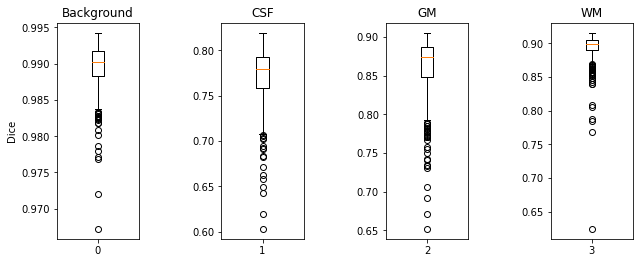

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3))
for i in range(4):
    axs[i].boxplot(dice_train[:, i], positions=[i])
    if i == 0:
        axs[i].set_title('Background')
        axs[i].set(ylabel="Dice")
    if i == 1:
        axs[i].set_title('CSF')
    if i == 2:
        axs[i].set_title('GM')
    if i == 3:
        axs[i].set_title('WM')

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=1)
plt.show()

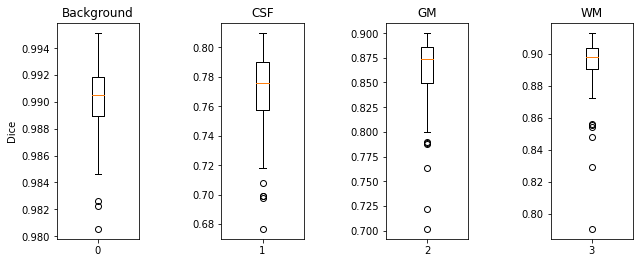

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3))
for i in range(4):
    axs[i].boxplot(dice_test[:, i], positions=[i])
    if i == 0:
        axs[i].set_title('Background')
        axs[i].set(ylabel="Dice")
    if i == 1:
        axs[i].set_title('CSF')
    if i == 2:
        axs[i].set_title('GM')
    if i == 3:
        axs[i].set_title('WM')

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=1)
plt.show()

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [26]:
import os

seg_dir = './output/SimpleNet3D_model_pred/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

def get_volumes(reg):
    volumes = np.zeros((3, len(reg)))
    for id, _ in enumerate(tqdm(range(len(reg)), desc='Calculating')):
        seg_filename = reg[id]
        if os.path.exists(seg_filename):

            segmentation = sitk.ReadImage(seg_filename)
            size = segmentation.GetSize()
            spacing = segmentation.GetSpacing()
            segmentation = sitk.GetArrayFromImage(segmentation)

            width = (size[0] * spacing[0])
            height = (size[1] * spacing[1])
            depth = (size[2] * spacing[2])

            segmentation = torch.tensor(segmentation).type(torch.int64)
            segmentation = segmentation.squeeze(1)

            segmentation = F.one_hot(segmentation, num_classes=4) 
            segmentation = segmentation.permute(3, 0, 1, 2)
            
            img_vol = width * height * depth

            for i in range(3):
                c = i + 1
                class_i = segmentation[c, :, :, :]
                class_f = class_i.reshape(1, -1)
                class_f = class_f.numpy()
                volumes[i, id] = (img_vol * np.sum(class_f) / class_f.shape[1])
    return volumes

In [27]:
vols_train = get_volumes(files_reg_seg_train)

Calculating: 100%|██████████| 500/500 [00:03<00:00, 148.26it/s]


Plot features versus age.

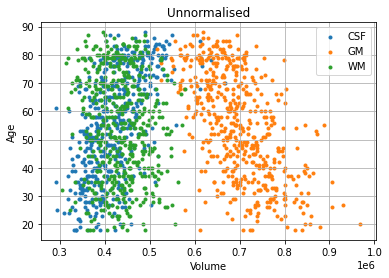

In [28]:
plt.scatter(vols_train[0, :], meta_data_reg_train['age'], marker='.')
plt.scatter(vols_train[1, :], meta_data_reg_train['age'], marker='.')
plt.scatter(vols_train[2, :], meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF', 'GM', 'WM'))
plt.savefig("unnormalised.pdf")
plt.show()

In [29]:
vols_normalised_train = np.zeros((3,len(files_reg_seg_train)))

def normalise(files_reg_seg,vols,vols_normalised):
    for j in range(len(files_reg_seg)):
      total_volume = np.sum(vols[:,j])
      for i in range(3):
        vols_normalised[i,j] = vols[i,j] / total_volume
    return vols_normalised

vols_normalised_train=normalise(files_reg_seg_train,vols_train,vols_normalised_train)
print(vols_normalised_train.shape)

(3, 500)


Plot normalised features versus age.

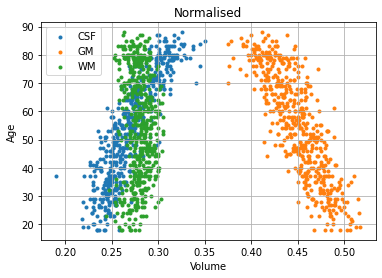

In [30]:
plt.scatter(vols_normalised_train[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised_train[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised_train[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.savefig("normalised.pdf")
plt.show()

Final data

In [31]:
X = vols_normalised_train.T
Y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(Y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.


Fold 1
Linear Regression: mae= 7.50938 , r2= 0.72225
K Neighbors Regression: mae= 7.138 , r2 = 0.7308
MLP: mae= 7.1562 , r2 = 0.74346
Bayesian Ridge Regression: mae = 7.51 , r2 = 0.72
Lasso Regression: mae= 7.65 , r2 = 0.72

Fold 2
Linear Regression: mae= 7.7115 , r2= 0.74175
K Neighbors Regression: mae= 7.392 , r2 = 0.75043
MLP: mae= 7.08881 , r2 = 0.77384
Bayesian Ridge Regression: mae = 7.71 , r2 = 0.74
Lasso Regression: mae= 7.96 , r2 = 0.73


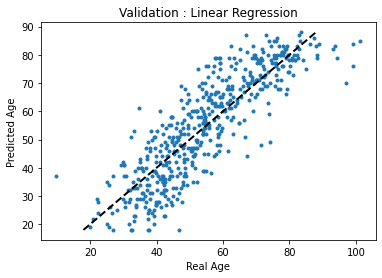

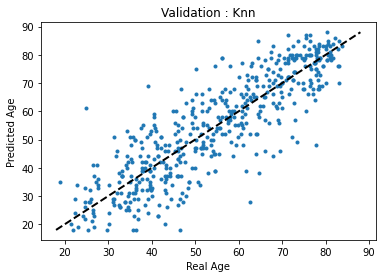

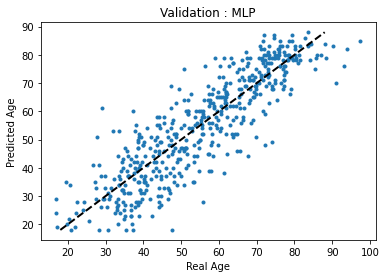

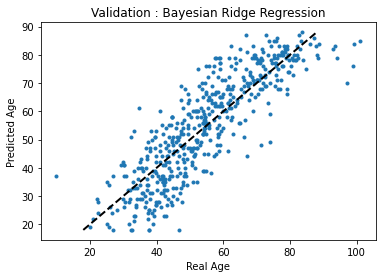

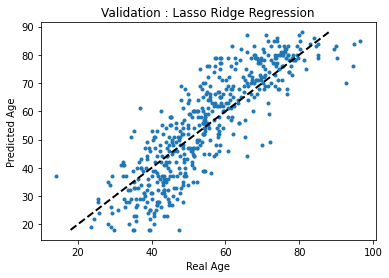

In [57]:
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=rnd_seed)

lr_two_fold_preds = []
knn_two_fold_preds = []
ridge_two_fold_preds = []
mlp_two_fold_preds = []
ls_two_fold_preds = []

y_two_fold_val = []


for i, (train_index, val_index) in enumerate(kf.split(X)):
  print('\nFold', i + 1)
  x_train = X[train_index].reshape(len(train_index), -1)
  x_val = X[val_index].reshape(len(val_index), -1)

  y_train = Y[train_index].ravel()
  y_val = Y[val_index].ravel()

  y_two_fold_val.append(y_val)


####################### linear regression #######################
  lr = LinearRegression()
  lr.fit(x_train, y_train)
  lr_pred = lr.predict(x_val)
  lr_two_fold_preds.append(lr_pred)
  lr_mae = np.round(mean_absolute_error(y_val, lr_pred), 5)
  lr_r2 = np.round(r2_score(y_val, lr_pred), 5)
  print('Linear Regression: mae=', lr_mae, ', r2=', lr_r2)


####################### knn #######################
  knn = KNeighborsRegressor(n_neighbors=4, algorithm='auto')
  knn.fit(x_train, y_train)
  knn_pred = knn.predict(x_val)
  knn_two_fold_preds.append(knn_pred)
  knn_mae = np.round(mean_absolute_error(y_val, knn_pred), 5)
  knn_r2 = np.round(r2_score(y_val, knn_pred), 5)
  print('K Neighbors Regression: mae=', knn_mae, ', r2 =', knn_r2)

####################### mlp #######################
  hidden_layer_size_mlp = (100, 100)
  activation_mlp = 'relu'
  learning_rate_mlp = 0.001
  optimizer_mlp = 'adam'
  mlp = make_pipeline(StandardScaler(),MLPRegressor(
      hidden_layer_sizes=hidden_layer_size_mlp,
      tol=1e-2, max_iter=1000, random_state=0,
      early_stopping=False,
      learning_rate_init=learning_rate_mlp,
      solver=optimizer_mlp)
  )
  mlp.fit(x_train, y_train)
  mlp_pred = mlp.predict(x_val)
  mlp_two_fold_preds.append(mlp_pred)
  mlp_mae = np.round(mean_absolute_error(y_val, mlp_pred), 5)
  mlp_r2 = np.round(r2_score(y_val, mlp_pred), 5)
  print('MLP: mae=', mlp_mae, ', r2 =', mlp_r2)

####################### Bayesian Ridge Regression #######################
  br = BayesianRidge(normalize=True)
  br.fit(x_train, y_train)
  ridge_pred = br.predict(x_val)
  ridge_two_fold_preds.append(ridge_pred)
  ridge_mae = np.round(mean_absolute_error(y_val, ridge_pred), 2)
  ridge_r2 = np.round(r2_score(y_val, ridge_pred), 2)
  print('Bayesian Ridge Regression: mae =', ridge_mae, ', r2 =', ridge_r2)

####################### Lasso Ridge Regression #######################
  ls = LassoLars(alpha=0.1)
  ls.fit(x_train, y_train)
  ls_pred = ls.predict(x_val)
  ls_two_fold_preds.append(ls_pred)
  ls_valid_mae = np.round(mean_absolute_error(y_val, ls_pred), 2)
  ls_valid_r2 = np.round(r2_score(y_val, ls_pred), 2)
  print('Lasso Regression: mae=', ls_valid_mae, ', r2 =', ls_valid_r2)

## End the 2 fold. Begin the plot.

####################### plot linear regression #######################
fig, ax = plt.subplots()
ax.scatter(lr_two_fold_preds, y_two_fold_val, marker='.')
ax.plot([np.min(y_two_fold_val), np.max(y_two_fold_val)], [np.min(y_two_fold_val), np.max(y_two_fold_val)], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Validation : Linear Regression')
plt.savefig('real_vs_predict_valid.pdf')
plt.show()

####################### plot Knn #######################
fig, ax = plt.subplots()
ax.scatter(knn_two_fold_preds, y_two_fold_val, marker='.')
ax.plot([np.min(y_two_fold_val), np.max(y_two_fold_val)], [np.min(y_two_fold_val), np.max(y_two_fold_val)], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Validation : Knn')
plt.savefig('real_vs_predict_valid.pdf')
plt.show()

####################### plot MLP #######################
fig, ax = plt.subplots()
ax.scatter(mlp_two_fold_preds, y_two_fold_val, marker='.')
ax.plot([np.min(y_two_fold_val), np.max(y_two_fold_val)], [np.min(y_two_fold_val), np.max(y_two_fold_val)], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Validation : MLP')
plt.savefig('real_vs_predict_valid.pdf')
plt.show()

####################### plot Bayesian Ridge Regression #######################
fig, ax = plt.subplots()
ax.scatter(ridge_two_fold_preds, y_two_fold_val, marker='.')
ax.plot([np.min(y_two_fold_val), np.max(y_two_fold_val)], [np.min(y_two_fold_val), np.max(y_two_fold_val)], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Validation : Bayesian Ridge Regression')
plt.savefig('real_vs_predict_valid.pdf')
plt.show()

####################### plot Lasso Ridge Regression #######################
fig, ax = plt.subplots()
ax.scatter(ls_two_fold_preds, y_two_fold_val, marker='.')
ax.plot([np.min(y_two_fold_val), np.max(y_two_fold_val)], [np.min(y_two_fold_val), np.max(y_two_fold_val)], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Validation : Lasso Ridge Regression')
plt.savefig('real_vs_predict_valid.pdf')
plt.show()


### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [34]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-03-03 13:27:31--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip.1’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-03-03 13:27:31 (243 MB/s) - ‘brainage-testdata.zip.1’ saved [1521/1521]

Archive:  brainage-testdata.zip
replace data/brain_age/meta/meta_data_regression_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [58]:
seg_dir = './output/SimpleNet3D_model_pred/'

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

In [37]:
vols_test = get_volumes(files_reg_seg_test)
vols_normalised_test = np.zeros((3,len(files_reg_seg_test)))
vols_normalised_test = normalise(files_reg_seg_test,vols_test,vols_normalised_test)

X_test = vols_normalised_test.T
Y_test = meta_data_reg_test['age'].values.reshape(-1,1)

Calculating: 100%|██████████| 100/100 [00:00<00:00, 141.32it/s]


#### Run final testing

In [59]:
def mlp(x_train, y_train, X_test, Y_test):
  hidden_layer_size_mlp = (100, 100)
  activation_mlp = 'relu'
  learning_rate_mlp = 0.001
  optimizer_mlp = 'adam'
  mlp = make_pipeline(StandardScaler(),MLPRegressor(
      hidden_layer_sizes=hidden_layer_size_mlp,
      tol=1e-2, max_iter=1000, random_state=0,
      early_stopping=False,
      learning_rate_init=learning_rate_mlp,
      solver=optimizer_mlp)
  )
  mlp.fit(x_train, y_train)
  mlp_pred = mlp.predict(X_test)
  mlp_mae = np.round(mean_absolute_error(Y_test, mlp_pred), 5)
  mlp_r2 = np.round(r2_score(Y_test, mlp_pred), 5)
  print('MLP: mae=', mlp_mae, ', r2 =', mlp_r2)
  return mlp_mae, mlp_r2, mlp_pred


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP: mae= 6.81826 , r2 = 0.81883


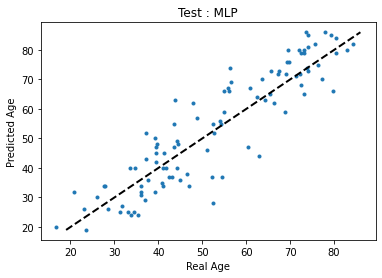

In [60]:
mlp_mae, mlp_r2, mlp_pre_list= mlp(X, Y, X_test, Y_test)
####################### plot MLP #######################
fig, ax = plt.subplots()
ax.scatter(mlp_pre_list, Y_test, marker='.')
ax.plot([np.min(Y_test), np.max(Y_test)], [np.min(Y_test), np.max(Y_test)], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Test : MLP')
plt.savefig('real_vs_predict_valid.pdf')
plt.show()

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

# import necessary library

In [41]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Read the meta data using pandas
import pandas as pd

check GPU

In [42]:
cuda_dev = '0'  # GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))

Device: cuda:0
GPU: Tesla P100-PCIE-16GB


# Data Helper for task B.
including:

zero mean unit var : Normalizes an image to zero mean and unit variance.

resample_image :  Resamples an image to given element spacing and output size.


ImageRegressionDataset : Dataset for age regression.



In [43]:
# Data helpers for regression

def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised



def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(
            np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(
        image.GetDirection()).reshape(len(original_spacing), -1)
    original_center = (np.array(original_size, dtype=float) -
                       1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / \
        2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageRegressionDataset(Dataset):
    """Dataset for image regression."""

    def __init__(self, meta_data_reg, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []

        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            # need to extract the ID to find the age
            
            ID = self.get_ID_from_path(file_list_img[idx])
            age = meta_data_reg.loc[meta_data_reg['subject_id'] == ID, 'age']
            age = age.item()

            # Extract each scan
            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            # pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        age = self.samples[item]['age']

        return {'img': image, 'seg': seg, 'msk': msk, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

    def get_ID_from_path(self, path):# get the ID to match age
        ID = path[-28:-20]
        return ID

# load the train regression data(500), and split it to two equal parts.

fix the seed

In [44]:
import random
def fix_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
fix_seed()

In [45]:
from torch.utils.data.sampler import SubsetRandomSampler
fix_seed()
data_dir = 'data/brain_age/'

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

meta_data_reg_train_taskB1 = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train_taskB1['subject_id'])
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]
files_reg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]
files_reg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_train]


# Loading training data
dataset = ImageRegressionDataset(
    meta_data_reg_train_taskB1, files_reg_img_train, files_reg_seg_train, files_reg_msk_train, img_spacing, img_size)

Loading Data: 100%|██████████| 500/500 [01:44<00:00,  4.79it/s]


Split the data into two parts. One is train, one is validation.

In [46]:
# split the dataset into train and validation dataloaders
fix_seed()
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.5 * num_train))

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 25 # need to equal with the later batch size

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=valid_sampler
)

set the hyperparameters

In [47]:
fix_seed()

num_epochs = 100
learning_rate = 0.0008 #with scheduler
batch_size = 25  #
num_classes = 1
val_interval = 10

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Our simple CNN.



In [48]:
# CNN Model
fix_seed()
import torch
import torch.nn as nn
import torch.nn.functional as F

feat_map_const = 16 #best 16

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()

        # Input is [batch_size, 1, 64, 64, 64])
        self.conv1 = nn.Conv3d(1, feat_map_const*4,
                               kernel_size=5, bias=True, padding=0)
        
        self.conv1_bn = nn.BatchNorm3d(feat_map_const*4)
        
        self.conv2 = nn.Conv3d(
            feat_map_const*4, feat_map_const*8, kernel_size=5, bias=True, padding=0)
        
        self.conv2_bn = nn.BatchNorm3d(feat_map_const*8)
        
        self.conv3 = nn.Conv3d(
            feat_map_const*8, feat_map_const*16, kernel_size=5, bias=True, padding=0)
        
        self.conv3_bn = nn.BatchNorm3d(feat_map_const*16)
        
        self.conv4 = nn.Conv3d(
            feat_map_const*16, feat_map_const*16, kernel_size=5, bias=True, padding=0)
        
        self.conv4_bn = nn.BatchNorm3d(feat_map_const*16)
        
        self.fc1 = nn.Linear(feat_map_const*16*5*5*5, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        
        x = F.max_pool3d(F.relu(self.conv1_bn(self.conv1(x))),
                         kernel_size=2, stride=2, padding=0, ceil_mode=False)
        
        x = F.max_pool3d(F.relu(self.conv2_bn(self.conv2(x))),
                         kernel_size=2, stride=2, padding=0, ceil_mode=False)
        
        x = F.relu(self.conv3_bn(self.conv3(x)))
        
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task B1 two fold
train

Total number of parameters is: 17418369
START TRAINING...
training -- epoch: 1 -- loss: 10.967938
validation -- epoch: 1 -- loss: 25.950541



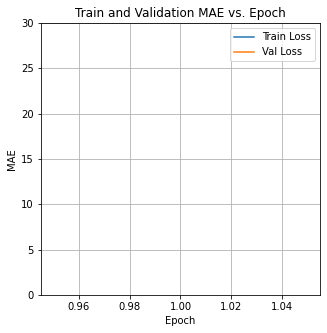

training -- epoch: 2 -- loss: 12.643146
training -- epoch: 3 -- loss: 9.062254
training -- epoch: 4 -- loss: 9.093730
training -- epoch: 5 -- loss: 8.769093
training -- epoch: 6 -- loss: 7.042333
training -- epoch: 7 -- loss: 16.014097
training -- epoch: 8 -- loss: 11.120008
training -- epoch: 9 -- loss: 6.473577
training -- epoch: 10 -- loss: 5.434150
validation -- epoch: 10 -- loss: 26.861914



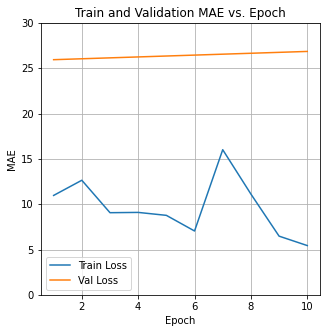

training -- epoch: 11 -- loss: 5.460823
training -- epoch: 12 -- loss: 3.821386
training -- epoch: 13 -- loss: 8.798950
training -- epoch: 14 -- loss: 3.556935
training -- epoch: 15 -- loss: 5.576600
training -- epoch: 16 -- loss: 10.346538
training -- epoch: 17 -- loss: 7.550100
training -- epoch: 18 -- loss: 4.854066
training -- epoch: 19 -- loss: 3.674856
training -- epoch: 20 -- loss: 3.352805
validation -- epoch: 20 -- loss: 11.928246



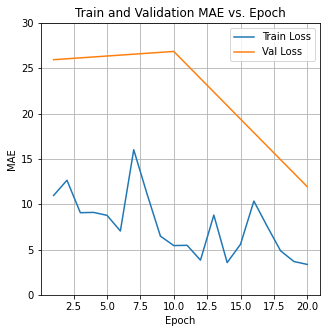

training -- epoch: 21 -- loss: 2.524756
training -- epoch: 22 -- loss: 4.444919
training -- epoch: 23 -- loss: 2.179009
training -- epoch: 24 -- loss: 2.388880
training -- epoch: 25 -- loss: 3.350832
training -- epoch: 26 -- loss: 3.809699
training -- epoch: 27 -- loss: 6.168355
training -- epoch: 28 -- loss: 4.081332
training -- epoch: 29 -- loss: 1.975754
training -- epoch: 30 -- loss: 1.953951
validation -- epoch: 30 -- loss: 9.163246



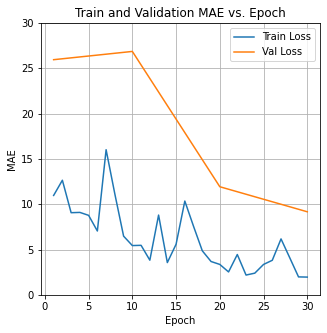

training -- epoch: 31 -- loss: 3.032495
training -- epoch: 32 -- loss: 2.747318
training -- epoch: 33 -- loss: 3.064681
training -- epoch: 34 -- loss: 1.031669
training -- epoch: 35 -- loss: 4.404902
training -- epoch: 36 -- loss: 2.159172
training -- epoch: 37 -- loss: 1.758376
training -- epoch: 38 -- loss: 2.245293
training -- epoch: 39 -- loss: 1.461340
training -- epoch: 40 -- loss: 1.079206
validation -- epoch: 40 -- loss: 5.836649



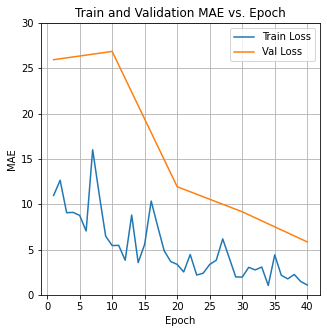

training -- epoch: 41 -- loss: 3.441982
training -- epoch: 42 -- loss: 6.501007
training -- epoch: 43 -- loss: 1.243801
training -- epoch: 44 -- loss: 2.309515
training -- epoch: 45 -- loss: 3.360473
training -- epoch: 46 -- loss: 1.760275
training -- epoch: 47 -- loss: 1.831020
training -- epoch: 48 -- loss: 3.516084
training -- epoch: 49 -- loss: 2.003127
training -- epoch: 50 -- loss: 1.099805
validation -- epoch: 50 -- loss: 5.955119



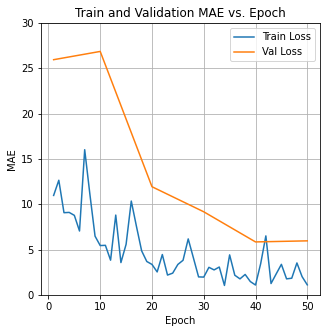

training -- epoch: 51 -- loss: 2.710922
training -- epoch: 52 -- loss: 5.175273
training -- epoch: 53 -- loss: 2.165059
training -- epoch: 54 -- loss: 1.236292
training -- epoch: 55 -- loss: 1.303733
training -- epoch: 56 -- loss: 1.357385
training -- epoch: 57 -- loss: 1.336686
training -- epoch: 58 -- loss: 1.431626
training -- epoch: 59 -- loss: 1.263283
training -- epoch: 60 -- loss: 1.037787
validation -- epoch: 60 -- loss: 5.772962



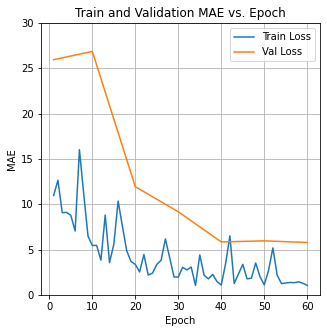

training -- epoch: 61 -- loss: 4.297337
training -- epoch: 62 -- loss: 4.193090
training -- epoch: 63 -- loss: 4.320223
training -- epoch: 64 -- loss: 1.595916
training -- epoch: 65 -- loss: 1.433204
training -- epoch: 66 -- loss: 4.480877
training -- epoch: 67 -- loss: 1.770667
training -- epoch: 68 -- loss: 2.973673
training -- epoch: 69 -- loss: 5.705488
training -- epoch: 70 -- loss: 1.276346
validation -- epoch: 70 -- loss: 5.818212



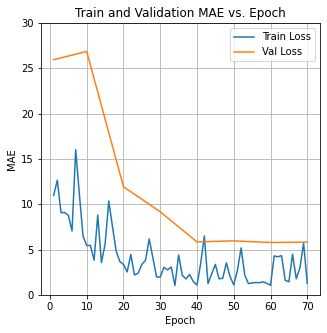

training -- epoch: 71 -- loss: 1.163920
training -- epoch: 72 -- loss: 1.223520
training -- epoch: 73 -- loss: 3.878105
training -- epoch: 74 -- loss: 3.402692
training -- epoch: 75 -- loss: 1.734526
training -- epoch: 76 -- loss: 1.766257
training -- epoch: 77 -- loss: 2.105245
training -- epoch: 78 -- loss: 1.530346
training -- epoch: 79 -- loss: 1.730788
training -- epoch: 80 -- loss: 4.473626
validation -- epoch: 80 -- loss: 5.774687



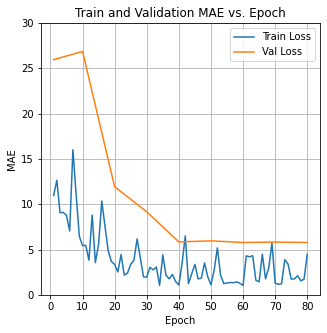

training -- epoch: 81 -- loss: 3.111573
training -- epoch: 82 -- loss: 4.763346
training -- epoch: 83 -- loss: 2.080977
training -- epoch: 84 -- loss: 1.122412
training -- epoch: 85 -- loss: 0.637548
training -- epoch: 86 -- loss: 0.840269
training -- epoch: 87 -- loss: 0.781959
training -- epoch: 88 -- loss: 0.828957
training -- epoch: 89 -- loss: 1.739428
training -- epoch: 90 -- loss: 7.186949
validation -- epoch: 90 -- loss: 5.814901



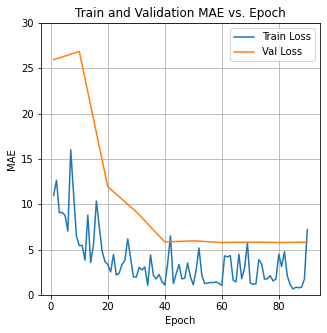

training -- epoch: 91 -- loss: 1.454785
training -- epoch: 92 -- loss: 1.667011
training -- epoch: 93 -- loss: 0.817100
training -- epoch: 94 -- loss: 4.018445
training -- epoch: 95 -- loss: 2.907743
training -- epoch: 96 -- loss: 4.678967
training -- epoch: 97 -- loss: 1.540674
training -- epoch: 98 -- loss: 0.977827
training -- epoch: 99 -- loss: 1.533736
training -- epoch: 100 -- loss: 3.123601
validation -- epoch: 100 -- loss: 5.791939



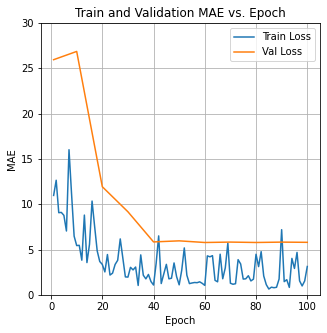


 The final curve graph:


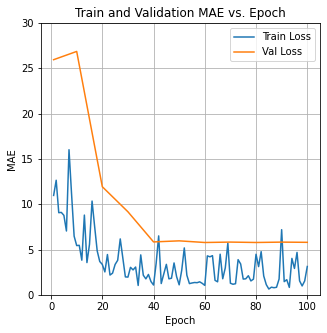


Finished TRAINING.
START TRAINING...
training -- epoch: 1 -- loss: 9.448693
validation -- epoch: 1 -- loss: 179.674805



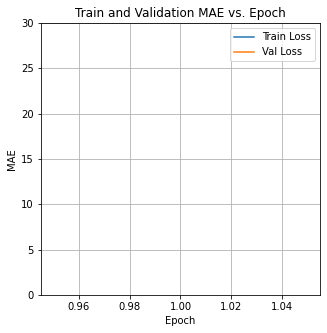

training -- epoch: 2 -- loss: 13.421071
training -- epoch: 3 -- loss: 11.750734
training -- epoch: 4 -- loss: 7.728208
training -- epoch: 5 -- loss: 7.406363
training -- epoch: 6 -- loss: 6.345943
training -- epoch: 7 -- loss: 10.124691
training -- epoch: 8 -- loss: 8.655997
training -- epoch: 9 -- loss: 10.195659
training -- epoch: 10 -- loss: 4.536429
validation -- epoch: 10 -- loss: 26.844791



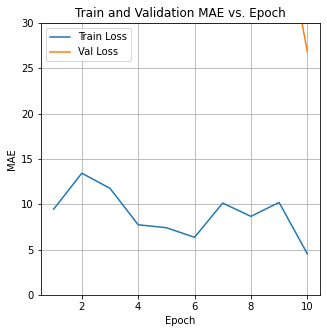

training -- epoch: 11 -- loss: 5.790346
training -- epoch: 12 -- loss: 5.312134
training -- epoch: 13 -- loss: 5.831035
training -- epoch: 14 -- loss: 4.069575
training -- epoch: 15 -- loss: 3.596019
training -- epoch: 16 -- loss: 4.922419
training -- epoch: 17 -- loss: 3.100441
training -- epoch: 18 -- loss: 3.754628
training -- epoch: 19 -- loss: 2.856851
training -- epoch: 20 -- loss: 5.070658
validation -- epoch: 20 -- loss: 12.569375



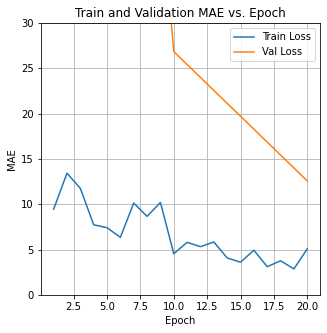

training -- epoch: 21 -- loss: 4.486206
training -- epoch: 22 -- loss: 3.364356
training -- epoch: 23 -- loss: 1.732801
training -- epoch: 24 -- loss: 2.640911
training -- epoch: 25 -- loss: 4.263207
training -- epoch: 26 -- loss: 4.970443
training -- epoch: 27 -- loss: 1.863838
training -- epoch: 28 -- loss: 2.925883
training -- epoch: 29 -- loss: 4.271312
training -- epoch: 30 -- loss: 4.171573
validation -- epoch: 30 -- loss: 9.575027



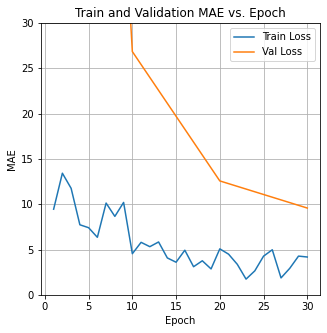

training -- epoch: 31 -- loss: 1.656523
training -- epoch: 32 -- loss: 3.173748
training -- epoch: 33 -- loss: 1.574706
training -- epoch: 34 -- loss: 1.499360
training -- epoch: 35 -- loss: 1.811677
training -- epoch: 36 -- loss: 5.776475
training -- epoch: 37 -- loss: 3.053868
training -- epoch: 38 -- loss: 0.932922
training -- epoch: 39 -- loss: 1.821965
training -- epoch: 40 -- loss: 2.010992
validation -- epoch: 40 -- loss: 5.996598



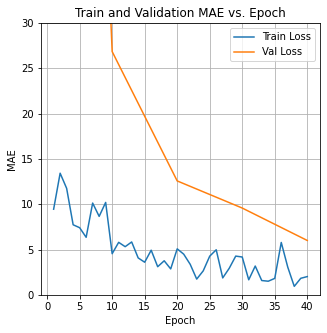

training -- epoch: 41 -- loss: 1.264665
training -- epoch: 42 -- loss: 0.963161
training -- epoch: 43 -- loss: 6.029083
training -- epoch: 44 -- loss: 0.874085
training -- epoch: 45 -- loss: 1.879871
training -- epoch: 46 -- loss: 5.713230
training -- epoch: 47 -- loss: 2.770234
training -- epoch: 48 -- loss: 7.817043
training -- epoch: 49 -- loss: 1.341887
training -- epoch: 50 -- loss: 0.662653
validation -- epoch: 50 -- loss: 5.884254



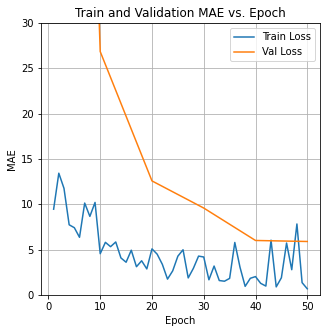

training -- epoch: 51 -- loss: 2.330371
training -- epoch: 52 -- loss: 4.098333
training -- epoch: 53 -- loss: 0.959987
training -- epoch: 54 -- loss: 3.940069
training -- epoch: 55 -- loss: 2.741795
training -- epoch: 56 -- loss: 2.330914
training -- epoch: 57 -- loss: 2.346477
training -- epoch: 58 -- loss: 3.868855
training -- epoch: 59 -- loss: 2.482466
training -- epoch: 60 -- loss: 6.553905
validation -- epoch: 60 -- loss: 5.893353



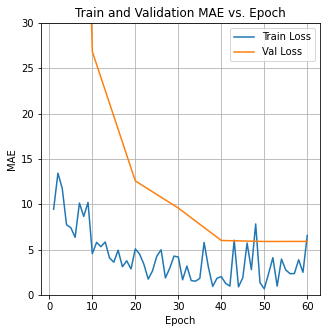

training -- epoch: 61 -- loss: 0.846380
training -- epoch: 62 -- loss: 0.470679
training -- epoch: 63 -- loss: 1.009406
training -- epoch: 64 -- loss: 0.595412
training -- epoch: 65 -- loss: 2.649736
training -- epoch: 66 -- loss: 2.243489
training -- epoch: 67 -- loss: 2.107968
training -- epoch: 68 -- loss: 1.133923
training -- epoch: 69 -- loss: 0.961733
training -- epoch: 70 -- loss: 6.243374
validation -- epoch: 70 -- loss: 5.906620



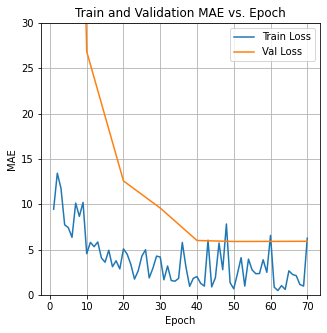

training -- epoch: 71 -- loss: 3.845605
training -- epoch: 72 -- loss: 2.823507
training -- epoch: 73 -- loss: 2.255524
training -- epoch: 74 -- loss: 0.740891
training -- epoch: 75 -- loss: 5.242142
training -- epoch: 76 -- loss: 0.795071
training -- epoch: 77 -- loss: 0.509999
training -- epoch: 78 -- loss: 1.850958
training -- epoch: 79 -- loss: 2.867136
training -- epoch: 80 -- loss: 2.626716
validation -- epoch: 80 -- loss: 5.874876



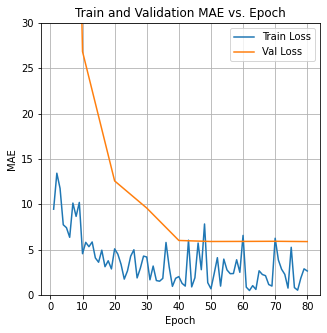

training -- epoch: 81 -- loss: 1.016112
training -- epoch: 82 -- loss: 0.646596
training -- epoch: 83 -- loss: 1.779943
training -- epoch: 84 -- loss: 5.145622
training -- epoch: 85 -- loss: 2.633476
training -- epoch: 86 -- loss: 4.894891
training -- epoch: 87 -- loss: 1.232951
training -- epoch: 88 -- loss: 0.838245
training -- epoch: 89 -- loss: 2.815739
training -- epoch: 90 -- loss: 2.221267
validation -- epoch: 90 -- loss: 5.889892



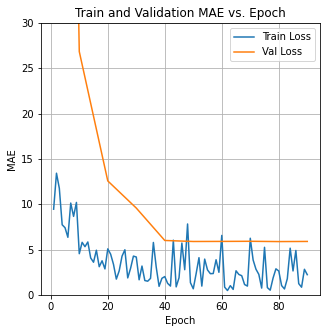

training -- epoch: 91 -- loss: 1.552354
training -- epoch: 92 -- loss: 2.127796
training -- epoch: 93 -- loss: 0.741669
training -- epoch: 94 -- loss: 2.204622
training -- epoch: 95 -- loss: 0.993661
training -- epoch: 96 -- loss: 3.134443
training -- epoch: 97 -- loss: 3.533043
training -- epoch: 98 -- loss: 1.191509
training -- epoch: 99 -- loss: 2.981876
training -- epoch: 100 -- loss: 2.761813
validation -- epoch: 100 -- loss: 5.892859



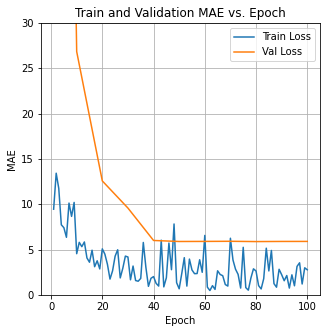


 The final curve graph:


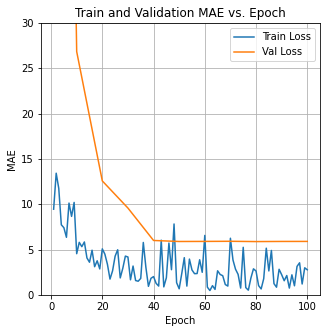


Finished TRAINING.


In [49]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import matplotlib.pyplot as plt

fix_seed()
data_loaders = [valid_loader, train_loader]

model_dir = os.path.join(out_dir, 'taskb1_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model = CNet().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

for n in range(2):

    #get the train and validation data for each 2 Fold.
    dataloader_val = data_loaders[n]
    dataloader_train = data_loaders[(n+1)%2]
    
    # reinitialise model
    model = CNet().to(device)

    model.train()

    # Adam is the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Add the scheduler to update the learning rate dynamicly.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.4) # add a scheduler to change the learning rate dynamic for each ten epoch.
    
    # reinitialise losses log list. (for plot)
    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
    epoch_train_log = []

    print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):
       ##################################### Train ######################################

        model.train()
        for batch_idx, batch_samples in enumerate(dataloader_train):
            sample = batch_samples['img'].to(device)

            label = batch_samples['age']
            label = label.to(device).reshape([batch_size, 1])
            optimizer.zero_grad()

            # Prediction should be age of subject
            prediction = model(sample)
            # Loss and backprop
            loss = F.l1_loss(prediction, label, reduction='mean')
            loss.backward()
            optimizer.step()

        loss_train_log.append(loss.item())
        print('training -- epoch: {} -- loss: {:.6f}'.format(epoch, loss.item()))
        scheduler.step()
      
        epoch_train_log.append(epoch)
      ##################################### End Train ######################################

      ##################################### Validation ######################################

      
            
        if epoch == 1 or epoch % val_interval == 0:
            model.eval()
            loss_val = 0
            loops = 0
            with torch.no_grad():
                for data_sample in dataloader_val:
                  loops += 1
                  sample = data_sample['img'].to(device)
                  label = data_sample['age']
                  label = label.to(device).reshape([batch_size, 1])
                  prediction = model(sample)
    
                  loss_val += F.l1_loss(prediction, label, reduction='mean')
            loss_val /= loops
            print('validation -- epoch: {} -- loss: {:.6f}'.format(epoch, loss_val))
            print()
            loss_val_log.append(loss_val.item())
            epoch_val_log.append(epoch)
            plt.figure(figsize=(5, 5))
            plt.plot(epoch_train_log, loss_train_log, label='Train Loss')
            plt.plot(epoch_val_log, loss_val_log, label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.ylim(0, 30)
            plt.legend()
            plt.grid()
            plt.title('Train and Validation MAE vs. Epoch')
            plt.show()

       ##################################### End Validation ######################################
    print("\n The final curve graph:")
    plt.figure(figsize=(5, 5))
    plt.plot(epoch_train_log, loss_train_log, label='Train Loss')
    plt.plot(epoch_val_log, loss_val_log, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim(0, 30)
    plt.legend()
    plt.grid()
    plt.title('Train and Validation MAE vs. Epoch')
    plt.show()
        
      
    torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

    print('\nFinished TRAINING.')

**Task B2 -- all train data** 
(validation from 47 segmentation train data)

Load the validation data (the 47 segmentation train data)

In [50]:
fix_seed()

batch_size = 25

# Making train and validation loaders
train_loader_total = torch.utils.data.DataLoader(dataset, batch_size)

meta_data_val_tashB2 = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_reg_val = list(meta_data_val_tashB2['subject_id'])

files_reg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_val]
files_reg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_val]
files_reg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_val]

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

dataset_val_taskB2 = ImageRegressionDataset(
    meta_data_val_tashB2, files_reg_img_val, files_reg_seg_val, files_reg_msk_val, img_spacing, img_size)

batch_size_val = 47
val_loader_total = torch.utils.data.DataLoader(dataset_val_taskB2, batch_size_val)

Loading Data: 100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


# train function

Total number of parameters is: 17418369
START TRAINING...
training -- epoch : 1; loss : 9.240264
validation -- epoch: 1; loss: 11.361601



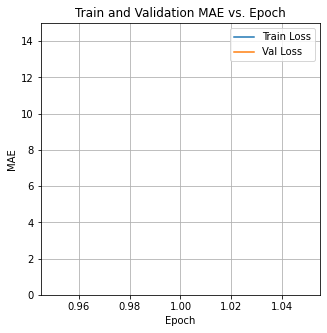

training -- epoch : 2; loss : 9.283525
training -- epoch : 3; loss : 6.812655
training -- epoch : 4; loss : 5.980241
training -- epoch : 5; loss : 4.843209
training -- epoch : 6; loss : 4.560985
training -- epoch : 7; loss : 4.583752
training -- epoch : 8; loss : 4.828147
training -- epoch : 9; loss : 8.080542
training -- epoch : 10; loss : 5.241681
validation -- epoch: 10; loss: 6.092447



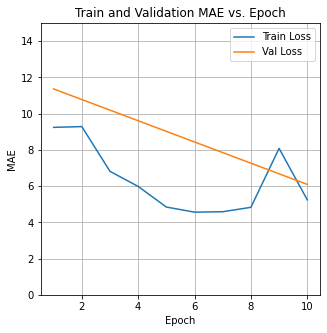

training -- epoch : 11; loss : 6.735435
training -- epoch : 12; loss : 7.448929
training -- epoch : 13; loss : 5.795771
training -- epoch : 14; loss : 5.171943
training -- epoch : 15; loss : 4.190905
training -- epoch : 16; loss : 4.117900
training -- epoch : 17; loss : 2.671715
training -- epoch : 18; loss : 2.479514
training -- epoch : 19; loss : 2.143264
training -- epoch : 20; loss : 2.348692
validation -- epoch: 20; loss: 5.415945



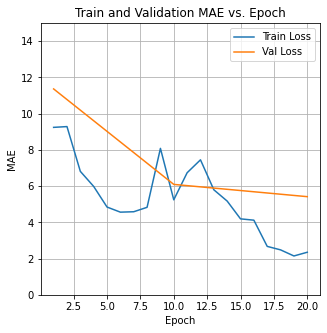

training -- epoch : 21; loss : 2.242130
training -- epoch : 22; loss : 2.316054
training -- epoch : 23; loss : 4.446247
training -- epoch : 24; loss : 1.520220
training -- epoch : 25; loss : 1.637455
training -- epoch : 26; loss : 1.223566
training -- epoch : 27; loss : 1.240219
training -- epoch : 28; loss : 1.117015
training -- epoch : 29; loss : 1.187659
training -- epoch : 30; loss : 1.077357
validation -- epoch: 30; loss: 5.293736



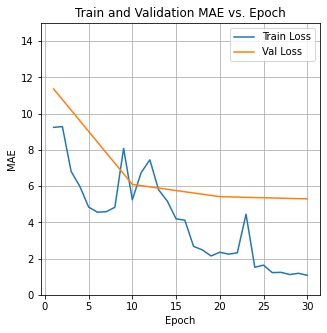

training -- epoch : 31; loss : 0.916779
training -- epoch : 32; loss : 0.825571
training -- epoch : 33; loss : 1.005867
training -- epoch : 34; loss : 1.631874
training -- epoch : 35; loss : 2.036676
training -- epoch : 36; loss : 1.107306
training -- epoch : 37; loss : 1.064822
training -- epoch : 38; loss : 1.191642
training -- epoch : 39; loss : 1.137286
training -- epoch : 40; loss : 1.110158
validation -- epoch: 40; loss: 6.174534



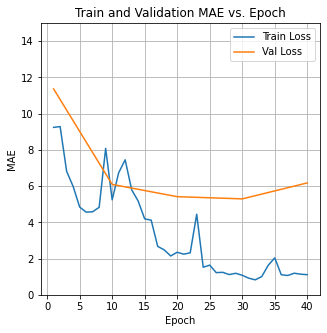

training -- epoch : 41; loss : 0.659409
training -- epoch : 42; loss : 0.507842
training -- epoch : 43; loss : 0.490909
training -- epoch : 44; loss : 0.404811
training -- epoch : 45; loss : 0.370802
training -- epoch : 46; loss : 0.394639
training -- epoch : 47; loss : 0.376943
training -- epoch : 48; loss : 0.328570
training -- epoch : 49; loss : 0.404120
training -- epoch : 50; loss : 0.316518
validation -- epoch: 50; loss: 5.770844



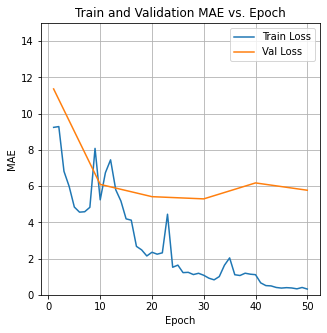

training -- epoch : 51; loss : 0.321885
training -- epoch : 52; loss : 0.331392
training -- epoch : 53; loss : 0.286988
training -- epoch : 54; loss : 0.271073
training -- epoch : 55; loss : 0.256874
training -- epoch : 56; loss : 0.247512
training -- epoch : 57; loss : 0.286684
training -- epoch : 58; loss : 0.256241
training -- epoch : 59; loss : 0.257698
training -- epoch : 60; loss : 0.260227
validation -- epoch: 60; loss: 5.734600



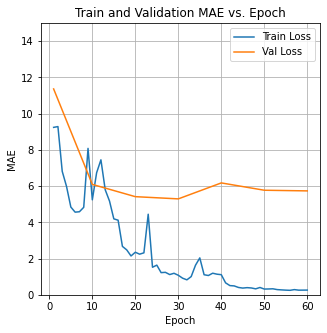

training -- epoch : 61; loss : 0.246477
training -- epoch : 62; loss : 0.244242
training -- epoch : 63; loss : 0.246931
training -- epoch : 64; loss : 0.245496
training -- epoch : 65; loss : 0.240759
training -- epoch : 66; loss : 0.237980
training -- epoch : 67; loss : 0.237558
training -- epoch : 68; loss : 0.237746
training -- epoch : 69; loss : 0.233463
training -- epoch : 70; loss : 0.232130
validation -- epoch: 70; loss: 5.743159



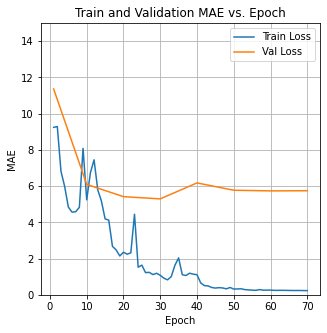

training -- epoch : 71; loss : 0.236173
training -- epoch : 72; loss : 0.237639
training -- epoch : 73; loss : 0.233533
training -- epoch : 74; loss : 0.232696
training -- epoch : 75; loss : 0.231614
training -- epoch : 76; loss : 0.231503
training -- epoch : 77; loss : 0.229733
training -- epoch : 78; loss : 0.229441
training -- epoch : 79; loss : 0.229306
training -- epoch : 80; loss : 0.230388
validation -- epoch: 80; loss: 5.737342



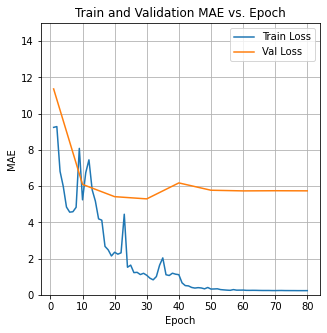

training -- epoch : 81; loss : 0.228842
training -- epoch : 82; loss : 0.228930
training -- epoch : 83; loss : 0.229108
training -- epoch : 84; loss : 0.228739
training -- epoch : 85; loss : 0.228346
training -- epoch : 86; loss : 0.228984
training -- epoch : 87; loss : 0.228482
training -- epoch : 88; loss : 0.227621
training -- epoch : 89; loss : 0.227849
training -- epoch : 90; loss : 0.227522
validation -- epoch: 90; loss: 5.736055



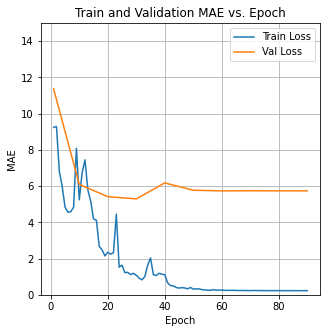

training -- epoch : 91; loss : 0.227543
training -- epoch : 92; loss : 0.227399
training -- epoch : 93; loss : 0.227962
training -- epoch : 94; loss : 0.227804
training -- epoch : 95; loss : 0.227249
training -- epoch : 96; loss : 0.227391
training -- epoch : 97; loss : 0.227412
training -- epoch : 98; loss : 0.227413
training -- epoch : 99; loss : 0.227364
training -- epoch : 100; loss : 0.227409
validation -- epoch: 100; loss: 5.735668



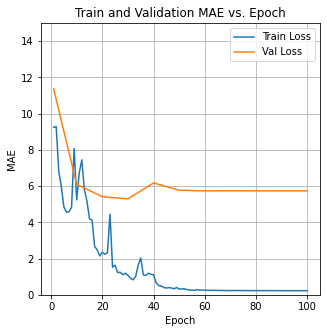


The final curve graph:


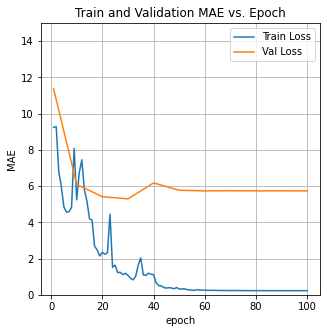


Finished TRAINING.


In [95]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

fix_seed()

## out_dir = ./output/ ##
## important reminder: the model_dir is the model address! you could find the mondel at out_dir/taskb2_model. ##
model_dir = os.path.join(out_dir, 'taskb2_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## check the model parameters number ##
model = CNet().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))


### big epoch will lead the overfitting, so set the num_epochs here with a small number is helpful. ###
num_epochs = 100


# for each dataloader
# Set each of the loaders
for n in range(1):
    
    ## load the train and val ##
    dataloader_train = train_loader_total
    dataloader_val = val_loader_total

    # reinitialise model
    model = CNet().to(device)

    model.train()
    ## optimizer = Adam ##
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ## scheduler = step lr, for each 8 epoch, lr = 0.4 * lr ##
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.4)

    ## reinitialise losses
    ## this log will be used in ploting ##
    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
    epoch_train_log = []
    
    print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):
        for batch_idx, batch_samples in enumerate(dataloader_train):

            sample = batch_samples['img'].to(device)
            label = batch_samples['age']
            label = label.to(device).reshape([batch_size, 1])

            optimizer.zero_grad()

            # Prediction should be age of subject
            prediction = model(sample)

            ## our loss function is l1_loss (MAE)
            loss = F.l1_loss(prediction, label, reduction='mean')

            loss.backward()
            optimizer.step()

        loss_train_log.append(loss.item())
        print('training -- epoch : {}; loss : {:.6f}'.format(epoch, loss.item()))
        scheduler.step()
        epoch_train_log.append(epoch)


        ## do validation for each 10 epoch ##
        if epoch == 1 or epoch % val_interval == 0:
            loss_val = 0
            loops = 0
            with torch.no_grad():
              for data_sample in dataloader_val:
                loops += 1
                samples = data_sample['img'].to(device)
                y = data_sample['age']
                y = y.to(device).view([batch_size_val, 1])


                ## get the result ##
                predicted = model(samples)
                loss_val += F.l1_loss(predicted, y, reduction='mean')
            

            ## calculate the loss of validation ##
            loss_val = loss_val / loops
            loss_val_log.append(loss_val.item())
            epoch_val_log.append(epoch)


            ## plot the temporarily graph ##
            print('validation -- epoch: {}; loss: {:.6f}'.format(epoch, loss_val))
            print()
            plt.figure(figsize=(5, 5))
            plt.plot(epoch_train_log, loss_train_log, label='Train Loss')
            plt.plot(epoch_val_log, loss_val_log, label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()
            plt.ylim(0, 15)
            plt.grid()
            plt.title('Train and Validation MAE vs. Epoch')
            plt.show()


    ## plot the final graph ##
    print("\nThe final curve graph:")
    plt.figure(figsize=(5, 5))
    plt.plot(range(1, num_epochs + 1), loss_train_log, label='Train Loss')
    plt.plot(epoch_val_log, loss_val_log, label='Val Loss')
    plt.xlabel('epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.ylim(0, 15)
    plt.grid()
    plt.title('Train and Validation MAE vs. Epoch')
    plt.show()
    torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))
    print('\nFinished TRAINING.')

# Do the final test.

In [73]:
meta_data_test_taskB2 = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_test_taskB2['subject_id'])

files_reg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_test]
files_reg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]
files_reg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_test]


img_size = [64, 64, 64]
img_spacing = [3, 3, 3]
dataset_test_taskB2 = ImageRegressionDataset(
    meta_data_test_taskB2, files_reg_img_test, files_reg_seg_test, files_reg_msk_test, img_spacing, img_size)

batch_size_test = 100
dataloader_test = torch.utils.data.DataLoader(
    dataset_test_taskB2, batch_size=batch_size_test)

Loading Data: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


In [31]:
model_dir

'./output/taskb2_model'

In [96]:
# load the model
#model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))

print(len(dataloader_test))
model.eval()

with torch.no_grad():
    for data_sample in dataloader_test:
        samples = data_sample['img'].to(device)
        y = data_sample['age']
        y = y.to(device).view([batch_size_test, 1])
        predicted = model(samples)

1


mean absolute error: 5.1479771614074705
r2 score: 0.8983348808795417


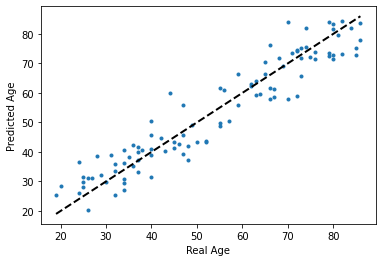

In [97]:
from sklearn.metrics import r2_score, mean_absolute_error

print('mean absolute error: {0}'.format(
    mean_absolute_error(y.cpu(), predicted.cpu())))
print('r2 score: {0}'.format(r2_score(y.cpu(), predicted.cpu())))

fig, ax = plt.subplots()
ax.scatter(y.cpu(), predicted.cpu(), marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()